<a href="https://colab.research.google.com/github/cyndroy/DP_Skin_Cancer_Classification_using_PATE/blob/master/DP_PATE_SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import time, os, random

# libary from pysyft needed to perform pate analysis
#from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
%cd '/content/drive/My Drive/Colab Notebooks/CancerDataset'

/content/drive/My Drive/Colab Notebooks/CancerDataset


In [6]:
class SkinCancerDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):

        benign_list = [[os.path.join(benign_path, filename),'0'] for filename in os.listdir(benign_path)] 
        malignant_list = [[os.path.join(malignant_path, filename),'1'] for filename in os.listdir(malignant_path)]
       
        self.img_list = []
        self.img_list = benign_list + malignant_list
        random.shuffle(self.img_list)

        self.transform = transform
      

    def __len__(self):
        return len(self.img_list)   

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx][1])
        return image, label

In [7]:
data_transforms = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = SkinCancerDataset(benign_path = './data/train/benign',
                             malignant_path = './data/train/malignant', transform = data_transforms)

testset = SkinCancerDataset(benign_path = './data/test/benign',
                             malignant_path = './data/test/malignant' , transform = data_transforms)

len(trainset),len(testset)

(2637, 660)

In [ ]:
print(trainset.__getitem__(0))
print(testset.__getitem__(0))

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


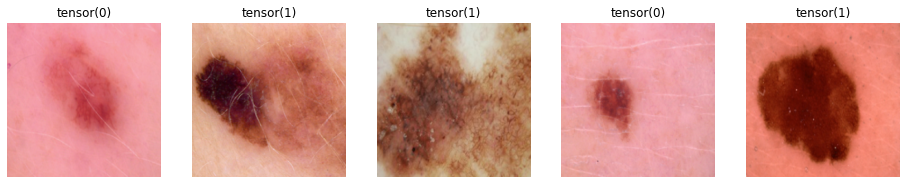

In [41]:
batchsize=16
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the train set
ii=0
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [8]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(trainset=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [9]:
#  # STUDENT
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(17, 5)